In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from uncertainties import ufloat
from uncertainties import unumpy as unp

$K^{\pm}$ \
Mass $m = 493.677 \pm 0.016$ MeV (S = 2.8) \
Mean life $\tau = (1.2380 \pm 0.0020) * 10^{-8}$ s (S = 1.8) \
$c\tau = 3.711$ m 

 

$\pi^{\pm}$ \
Mass $m = 139.57039 \pm 0.00018$ MeV (S = 1.8) \
Mean life $\tau = (2.6033 \pm 0.0005) * 10^{-8}$ s (S = 1.2) \
$c\tau = 7.8045$ m \
average decay length of $\pi^+ = 4188$ m

$T(x) = 0.84 \cdot \frac{1}{l_{\pi^+}} e^{-\frac{x}{l_{\pi^+}}} + 0.16 \cdot \frac{1}{l_{K^+}} e^{-\frac{x}{l_{K^+}}}$

In [3]:
def T(x, l_k):
    def P(x, l_p):
        return 1/l_p * np.exp(- 1/l_p * x)

    def K(x, l_k):
        return 1/l_k * np.exp(- 1/l_k * x)
    
    l_p = 4188 # m
    return 0.84 * P(x,l_p) + 0.16 * K(x,l_k)

def negative_log_of_likelihood_of_data(data, l_k):
    '''
        returns the log of the likelihood because the likelihood gets lower then the computer precision.
    '''
    log_of_likelihood = 0
    for x in data:
        log_of_likelihood += np.log(T(x, l_k))
    return -log_of_likelihood

def function_to_minimize(variables, data):
    '''
        We want to maximize the likelihood, but can only minimize a function.
        => minimize -likelihood
    '''
    l_k = variables[0]
    return negative_log_of_likelihood_of_data(data, l_k)

mean decay lenght Kaon 562.1709878966639 m


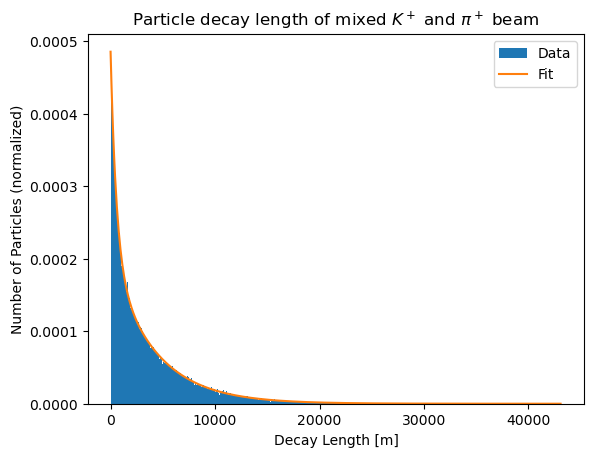

In [4]:
data = np.loadtxt('dec_lengths.txt')

counts, bins, _ = plt.hist(data, bins=500, density=True, label='Data')
xdata = bins[:-1]

res = minimize(function_to_minimize, x0=[500], args=(data), method='Powell')
mean_decay_lenght_Kaon = res.x[0]
print(f'mean decay lenght Kaon {mean_decay_lenght_Kaon} m')

# plot
plt.plot(xdata,T(xdata, res.x[0]), label='Fit')
plt.xlabel('Decay Length [m]')
plt.ylabel('Number of Particles (normalized)')
plt.title(r'Particle decay length of mixed $K^+$ and $\pi^+$ beam')
plt.legend()
plt.savefig('decay_length_of_mixed_beam.pdf')
plt.show()

In [5]:

# Calculate the uncertainty of l_k ----------------------------------------------------------------------
# we want to find the amount l_k has to be varied in order to change the neg log likelihood by 0.5 units

# get neg log likelihood curve
Xdata = np.linspace(550,574,8000)
# Ydata = [negative_log_of_likelihood_of_data(data, l_k) - res.fun - 0.5 for l_k in Xdata] 
# np.savetxt('neg log likelihood Ydata.txt', Ydata)
Ydata = np.loadtxt('neg log likelihood Ydata.txt')

# fit
fit_func = lambda x, a, b, c: a*x**2 + b*x + c
popt, pcov = curve_fit(fit_func, Xdata, Ydata)
perr = np.sqrt(np.diag(pcov))
a = ufloat(popt[0], perr[0])
b = ufloat(popt[1], perr[1])
c = ufloat(popt[2], perr[2])
# a = popt[0]
# b = popt[1]
# c = popt[2]

print('a: {:L}'.format(ufloat(popt[0], perr[0])))
print('b: {:L}'.format(ufloat(popt[1], perr[1])))
print('c: {:L}'.format(ufloat(popt[2], perr[2])))

# find root
try:
    root = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
except:
    root = (-b + unp.sqrt(b**2 - 4*a*c)) / (2*a)

uncertainty = np.abs(root - mean_decay_lenght_Kaon)
try:
    print('uncertainty: {:L}'.format(uncertainty))
    mean_decay_lenght_Kaon_uncertainty = uncertainty.n + uncertainty.s
except:
    print('uncertainty:', uncertainty)
    mean_decay_lenght_Kaon_uncertainty = uncertainty



a: 0.0050676 \pm 0.0000007
b: -5.7000 \pm 0.0008
c: 1602.35 \pm 0.23
uncertainty: 10 \pm 6


$\frac{l_{K^+}}{l_{\pi^+}} = \frac{m_{\pi^+}}{m_{K^+}} \frac{\tau_{K^+}}{\tau_{\pi^+}} \rightarrow \frac{l_{K^+}}{l_{\pi^+}}  \tau_{\pi^+} \frac{m_{K^+}}{m_{\pi^+}} = \tau_{K^+} $

In [8]:
l_k = ufloat(mean_decay_lenght_Kaon,mean_decay_lenght_Kaon_uncertainty) # m
l_p = ufloat(4188,0) # m
m_k = ufloat(493.677, 0.016) # MeV
m_p = ufloat(139.57039, 0.00018) # MeV
tau_p = ufloat(2.6033e-8, 0.0005e-8) # s

tau_k = l_k/l_p * tau_p * m_k/m_p
print(r'measured mean decay lenght $l_{K^+} =', '{:L}$'.format(l_k), 'm')
print(r'measured mean life time $\tau_{K^+, \, measured} =', '{:L}$'.format(tau_k), 's')
print(r'literature mean life time $\tau_{K^+,  \, literature} = \left(1.2380 \pm 0.0020\right) \times 10^{-8}$ s')

measured mean decay lenght $l_{K^+} = 562 \pm 16$ m
measured mean life time $\tau_{K^+, \, measured} = \left(1.236 \pm 0.035\right) \times 10^{-8}$ s
literature mean life time $\tau_{K^+,  \, literature} = \left(1.2380 \pm 0.0020\right) \times 10^{-8}$ s


measured mean decay lenght $l_{K^+} = 609.1 \pm 3.3$ m
measured mean life time curve fit $\tau_{K^+} = \left(1.339 \pm 0.007\right) \times 10^{-8}$ s
literature mean life time curve fit $\tau_{K^+} = \left(1.2380 \pm 0.0020\right) \times 10^{-8}$ s


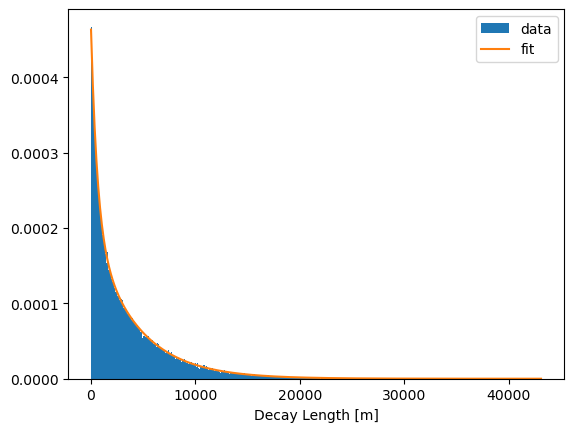

In [7]:
data = np.loadtxt('dec_lengths.txt')

counts, bins, _ = plt.hist(data,bins=500,density=True, label='data')
xdata = bins[:-1]
ydata = counts

def PDF(x, l_k):
    def p(x, l_p):
        return 1/l_p * np.exp(- 1/l_p * x)

    def k(x, l_k):
        return 1/l_k * np.exp(- 1/l_k * x)
    
    l_p = 4188 # m
    return 0.84 * p(x,l_p) + 0.16 * k(x,l_k)

opt_parms, parm_cov = curve_fit(PDF, xdata, ydata, p0=[500])
perr = np.sqrt(np.diag(parm_cov))

l_k = ufloat(opt_parms[0],perr[0]) # m
l_p = ufloat(4188,0) # m
m_k = ufloat(493.677, 0.016) # MeV
m_p = ufloat(139.57039, 0.00018) # MeV
tau_p = ufloat(2.6033e-8, 0.0005e-8) # s
print(r'measured mean decay lenght $l_{K^+} =', '{:L}$'.format(l_k), 'm')

tau_k = l_k/l_p * tau_p * m_k/m_p
print(r'measured mean life time curve fit $\tau_{K^+} =', '{:L}$'.format(tau_k), 's')
print(r'literature mean life time curve fit $\tau_{K^+} = \left(1.2380 \pm 0.0020\right) \times 10^{-8}$ s')

plt.plot(xdata, PDF(xdata, opt_parms[0]), label='fit')
plt.xlabel('Decay Length [m]')
plt.legend()
plt.show()